In [1]:
from sirf import STIR as pet
from ccpi.optimisation.operators import FiniteDiff
import numpy
import os

ag = pet.AcquisitionData('Siemens_mMR',span=11, view_mash_factor=2)
#pet.AcquisitionData.set_storage_scheme('memory')
ig = pet.ImageData(ag)
am = pet.AcquisitionModelUsingRayTracingMatrix()
am.set_up(ag,ig)

inp = ig.as_array()
print (inp.shape)
ig.fill(numpy.random.randint(100, size=ig.shape))


(127, 285, 285)


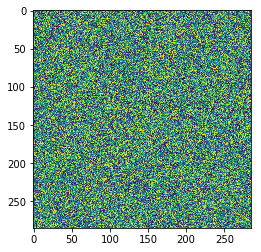

In [2]:
import matplotlib.pyplot as plt

plt.imshow(ig.as_array()[0])
plt.show()

<PIL.TiffImagePlugin.TiffImageFile image mode=L size=512x512 at 0x7F0A1AC61E10>
('data.geometry', <ccpi.framework.framework.ImageGeometry object at 0x7f0a1ac72790>)


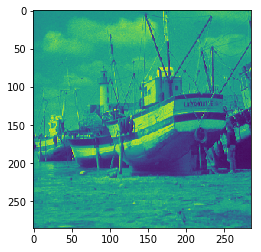

In [3]:
from ccpi.framework import TestData
from ccpi.optimisation.operators import *

loader = TestData(data_dir="/home/sirfuser/devel/install/share/ccpi")

boat = loader.load(TestData.BOAT, size=(285,285))
plt.imshow(boat.as_array())
plt.show()


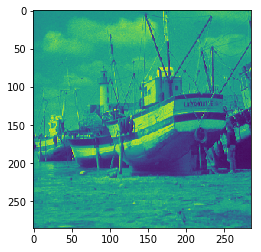

In [4]:
npig = ig.as_array()

for i in range(ig.shape[0]):
    #print (i)
    npig[i] = boat.as_array()[:]

ig.fill(npig)
plt.imshow(ig.as_array()[0])
plt.show()

In [5]:
FD = FiniteDiff(ig)

FD.direction = 0
dz = FD.direct(ig)

FD.direction = 1
dy = FD.direct(ig)

FD.direction = 2
dx = FD.direct(ig)


(<class 'sirf.STIR.ImageData'>, <class 'sirf.STIR.ImageData'>)


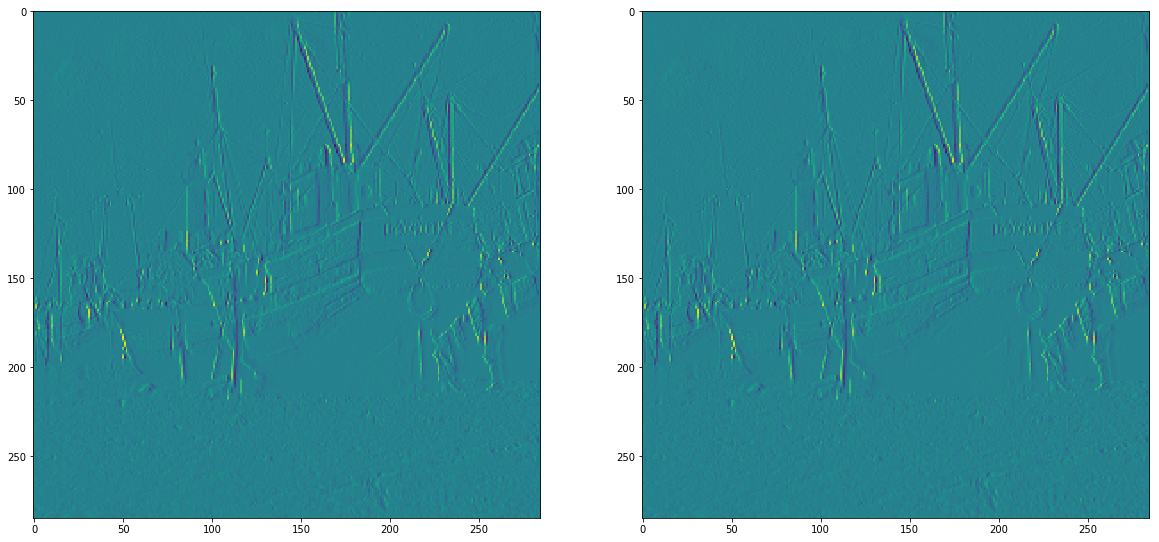

In [6]:
dx2 = dx.copy()
dx2.fill(0)
print(type(dx), type(dx2))

FD.direct(ig, out=dx2)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(dx.as_array()[0])
plt.subplot(1,2,2)
plt.imshow(dx2.as_array()[0])
plt.show()

In [7]:
(dx - dx2).as_array().min()

0.0

In [8]:
from ccpi.framework import BlockDataContainer
out = BlockDataContainer(dz,dy,dx)
print (out.shape) # 3,1
out2 = out * 2

(3, 1)


(127, 285, 285)
(127, 285, 285)


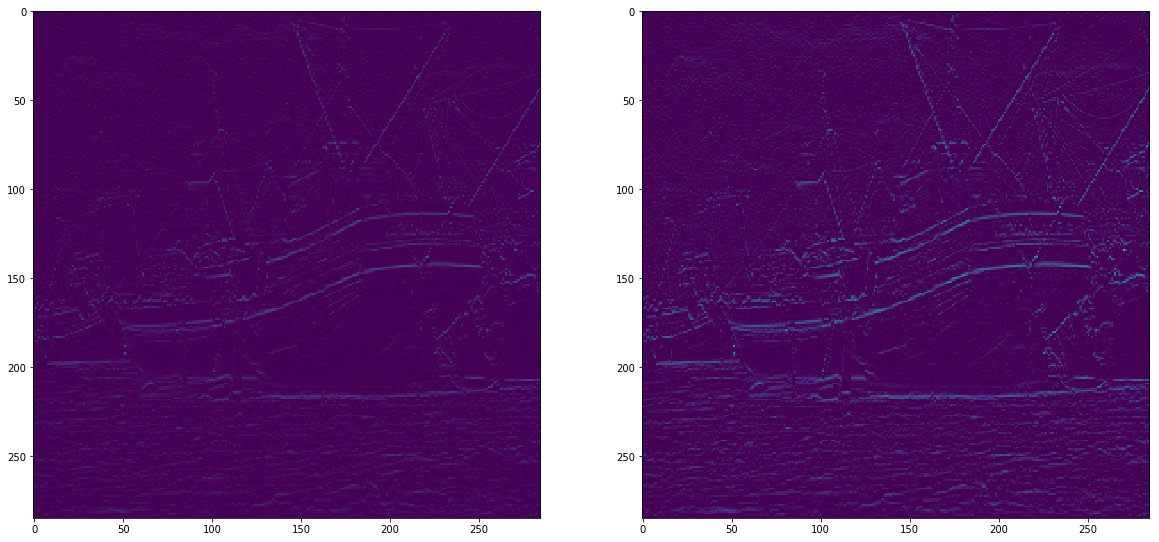

In [9]:
print(dx.shape)
print(ig.shape)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(out.get_item(1).as_array()[0])
plt.clim([0,2])
plt.subplot(1,2,2)
plt.imshow(out2.get_item(1).as_array()[0])
plt.clim([0,2])
plt.show()


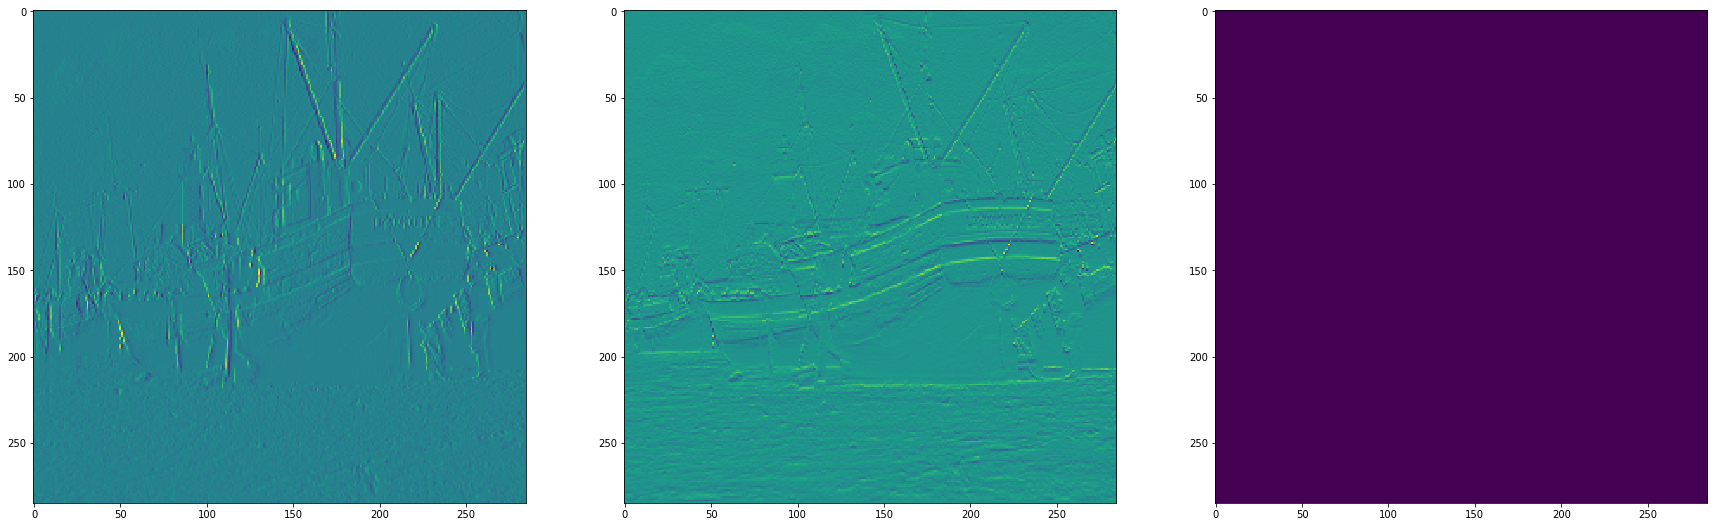

In [10]:
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.imshow(dx.as_array()[0])
plt.subplot(1,3,2)
plt.imshow(dy.as_array()[0])
plt.subplot(1,3,3)
plt.imshow(dz.as_array()[0])
plt.show()


In [11]:
FD.direction = 0
adj_dz = FD.adjoint(dz)

FD.direction = 1
adj_dy = FD.adjoint(dy)

FD.direction = 2
adj_dx = FD.adjoint(dx)



In [12]:
FD.direction = 2

adj_dx2 = adj_dx * 0
FD.adjoint(dx, out = adj_dx2)

diff = (adj_dx - adj_dx2).as_array()
print(diff.max(), diff.min())

(0.0, 0.0)


In [17]:
# -*- coding: utf-8 -*-
#  CCP in Tomographic Imaging (CCPi) Core Imaging Library (CIL).

#   Copyright 2017 UKRI-STFC
#   Copyright 2017 University of Manchester

#   Licensed under the Apache License, Version 2.0 (the "License");
#   you may not use this file except in compliance with the License.
#   You may obtain a copy of the License at

#   http://www.apache.org/licenses/LICENSE-2.0

#   Unless required by applicable law or agreed to in writing, software
#   distributed under the License is distributed on an "AS IS" BASIS,
#   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#   See the License for the specific language governing permissions and
#   limitations under the License.
from ccpi.optimisation.operators import Operator, LinearOperator, ScaledOperator
from ccpi.framework import ImageData, ImageGeometry, BlockGeometry, BlockDataContainer
import numpy 
from ccpi.optimisation.operators import FiniteDiff, SparseFiniteDiff, Gradient

#%%

class GradientSIRF(LinearOperator):
    
    
    r'''Gradient Operator: .. math:: \nabla : X -> Y           
            
            Computes first-order forward/backward differences 
                     on 2D, 3D, 4D ImageData
                     under Neumann/Periodic boundary conditions
                                                             
                Example (2D): u\in X, \nabla(u) = [\partial_{y} u, \partial_{x} u]
                              u^{*}\in Y, \nabla^{*}(u^{*}) = \partial_{y} v1 + \partial_{x} v2
        
                Grad_order = ['channels', 'direction_z', 'direction_y', 'direction_x']
                Grad_order = ['channels', 'direction_y', 'direction_x']
                Grad_order = ['direction_z', 'direction_y', 'direction_x']
                Grad_order = ['channels', 'direction_z', 'direction_y', 'direction_x']
                

    '''
    
                    
    def __init__(self, gm_domain, bnd_cond = 'Neumann', **kwargs):
        
        super(LinearOperator, self).__init__() 
                
        self.gm_domain = gm_domain # Domain of Grad Operator
        
        self.correlation = kwargs.get('correlation',Gradient.CORRELATION_SPACE)
        
        if self.correlation==Gradient.CORRELATION_SPACE:
            # SIRF ImageData has maximum 3 Dimensions
            self.gm_range = BlockGeometry(*[self.gm_domain for _ in range(len(self.gm_domain.shape)) ] )
            if len(self.gm_domain.shape) == 3:
                # 3D
                # expected Grad_order = ['direction_z', 'direction_y', 'direction_x']
                expected_order = [ImageGeometry.VERTICAL, ImageGeometry.HORIZONTAL_Y, ImageGeometry.HORIZONTAL_X]
                self.ind = [2,1,0]
            else:
                # 2D
                expected_order = [ImageGeometry.HORIZONTAL_Y, ImageGeometry.HORIZONTAL_X]    
                self.ind = [1,0]
            
        self.bnd_cond = bnd_cond 
        
        # Call FiniteDiff operator        
        self.FD = FiniteDiff(self.gm_domain, direction = 0, bnd_cond = self.bnd_cond)
                                                         
    def direct(self, x, out=None):
        
                
        if out is not None:
            
            for i in range(self.gm_range.shape[0]):
                self.FD.direction = self.ind[i]
                self.FD.direct(x, out = out[i])
        else:
            tmp = self.gm_range.allocate()        
            for i in range(tmp.shape[0]):
                self.FD.direction=self.ind[i]
                tmp.get_item(i).fill(self.FD.direct(x))
            return tmp    
        
    def adjoint(self, x, out=None):
        
        if out is not None:

            tmp = self.gm_domain.allocate()            
            for i in range(x.shape[0]):
                self.FD.direction=self.ind[i] 
                self.FD.adjoint(x.get_item(i), out = tmp)
                if i == 0:
                    out.fill(tmp)
                else:
                    out += tmp
        else:            
            tmp = self.gm_domain.allocate()
            for i in range(x.shape[0]):
                self.FD.direction=self.ind[i]

                tmp += self.FD.adjoint(x.get_item(i))
            return tmp    
            
    
    def domain_geometry(self):
        
        '''Returns domain_geometry of Gradient'''
        
        return self.gm_domain
    
    def range_geometry(self):
        
        '''Returns range_geometry of Gradient'''
        
        return self.gm_range
    
    def __rmul__(self, scalar):
        
        '''Multiplication of Gradient with a scalar        
            
            Returns: ScaledOperator
        '''        
        
        return ScaledOperator(self, scalar) 
    
    ###########################################################################
    ###############  For preconditioning ######################################
    ###########################################################################
    def matrix(self):
        
        tmp = self.gm_range.allocate()
        
        mat = []
        for i in range(tmp.shape[0]):
            
            spMat = SparseFiniteDiff(self.gm_domain, direction=self.ind[i], bnd_cond=self.bnd_cond)
            mat.append(spMat.matrix())
    
        return BlockDataContainer(*mat)    


    def sum_abs_col(self):
        
        tmp = self.gm_range.allocate()
        res = self.gm_domain.allocate()
        for i in range(tmp.shape[0]):
            spMat = SparseFiniteDiff(self.gm_domain, direction=self.ind[i], bnd_cond=self.bnd_cond)
            res += spMat.sum_abs_row()
        return res
    
    def sum_abs_row(self):
        
        tmp = self.gm_range.allocate()
        res = []
        for i in range(tmp.shape[0]):
            spMat = SparseFiniteDiff(self.gm_domain, direction=self.ind[i], bnd_cond=self.bnd_cond)
            res.append(spMat.sum_abs_col())
        return BlockDataContainer(*res)
   

   
       

In [29]:
grad = GradientSIRF(ig)

print (type(ig))
dxdy = grad.direct(ig)
out = dxdy * 0
grad.direct(ig, out=out)

for i in range (3):
    numpy.testing.assert_array_equal(out.get_item(i).as_array() , dxdy.get_item(i).as_array())

<class 'sirf.STIR.ImageData'>


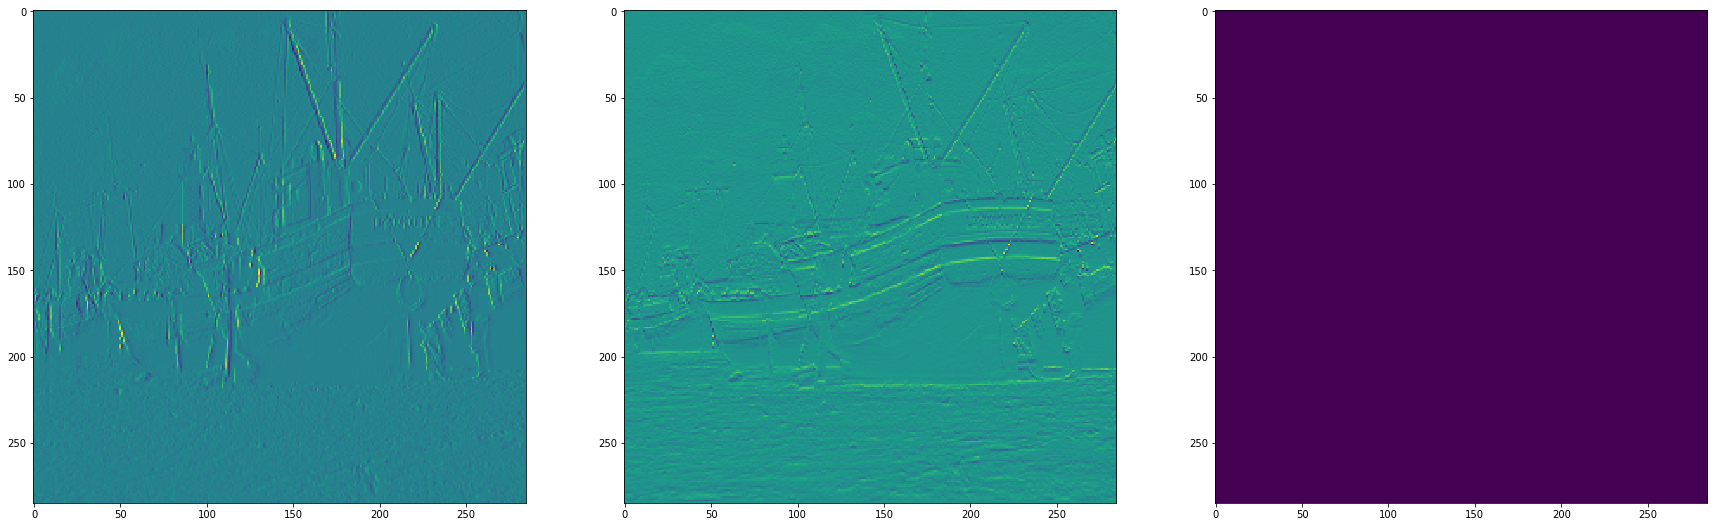

In [21]:
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.imshow(dxdy.get_item(0).as_array()[0])
plt.subplot(1,3,2)
plt.imshow(dxdy.get_item(1).as_array()[0])
plt.subplot(1,3,3)
plt.imshow(dxdy.get_item(2).as_array()[0])
plt.show()

In [31]:
adj_dxdy = grad.adjoint(dxdy)
out = adj_dxdy * 0
grad.adjoint(dxdy, out=out)

In [32]:
numpy.testing.assert_array_equal((adj_dz + adj_dy + adj_dx).as_array() , adj_dxdy.as_array())
numpy.testing.assert_array_equal(out.as_array() , adj_dxdy.as_array())

In [ ]:
if __name__ == '__main__':
    
    
    from ccpi.optimisation.operators import Identity, BlockOperator
    
    
    M, N = 20, 30
    ig = ImageGeometry(M, N)
    arr = ig.allocate('random_int' )
    
    # check direct of Gradient and sparse matrix
    G = Gradient(ig)
    norm1 = G.norm(iterations=300)
    print ("should be sqrt(8) {} {}".format(numpy.sqrt(8), norm1))
    G_sp = G.matrix()
    ig4 = ImageGeometry(M,N, channels=3)
    G4 = Gradient(ig4, correlation=Gradient.CORRELATION_SPACECHANNEL)
    norm4 = G4.norm(iterations=300)
    print ("should be sqrt(12) {} {}".format(numpy.sqrt(12), norm4))
    

    res1 = G.direct(arr)
    res1y = numpy.reshape(G_sp[0].toarray().dot(arr.as_array().flatten('F')), ig.shape, 'F')
    
    print(res1[0].as_array())
    print(res1y)
    
    res1x = numpy.reshape(G_sp[1].toarray().dot(arr.as_array().flatten('F')), ig.shape, 'F')
    
    print(res1[1].as_array())
    print(res1x)    
    
    #check sum abs row
    conc_spmat = numpy.abs(numpy.concatenate( (G_sp[0].toarray(), G_sp[1].toarray() )))
    print(numpy.reshape(conc_spmat.sum(axis=0), ig.shape, 'F'))    
    print(G.sum_abs_row().as_array())
    
    print(numpy.reshape(conc_spmat.sum(axis=1), ((2,) + ig.shape), 'F'))
    
    print(G.sum_abs_col()[0].as_array())
    print(G.sum_abs_col()[1].as_array())   
    
    # Check Blockoperator sum abs col and row
    
    op1 = Gradient(ig)
    op2 = Identity(ig)
    
    B = BlockOperator( op1, op2)
    
    Brow = B.sum_abs_row()
    Bcol = B.sum_abs_col()
    
    concB = numpy.concatenate( (numpy.abs(numpy.concatenate( (G_sp[0].toarray(), G_sp[1].toarray() ))), op2.matrix().toarray()))
    
    print(numpy.reshape(concB.sum(axis=0), ig.shape, 'F'))
    print(Brow.as_array())
    
    print(numpy.reshape(concB.sum(axis=1)[0:12], ((2,) + ig.shape), 'F'))
    print(Bcol[1].as_array())    
    
        
#    print(numpy.concatene(G_sp[0].toarray()+ ))
#    print(G_sp[1].toarray())
#    
#    d1 = G.sum_abs_row()
#    print(d1.as_array())
#    
#    d2 = G_neum.sum_abs_col()
##    print(d2)    
#    
#    
#    ###########################################################
    a = BlockDataContainer( BlockDataContainer(arr, arr), arr)
    b = BlockDataContainer( BlockDataContainer(arr+5, arr+3), arr+2)
    c = a/b
    
    print(c[0][0].as_array(), (arr/(arr+5)).as_array())
    print(c[0][1].as_array(), (arr/(arr+3)).as_array())
    print(c[1].as_array(), (arr/(arr+2)).as_array())
    
    
    a1 = BlockDataContainer( arr, BlockDataContainer(arr, arr))
#    
#    c1 = arr + a
#    c2 = arr + a
#    c2 = a1 + arr
    
    from ccpi.framework import ImageGeometry
#    from ccpi.optimisation.operators import Gradient
#
    N, M = 2, 3
#    
    ig = ImageGeometry(N, M)
#
    G = Gradient(ig)
#
    u = G.domain_geometry().allocate('random_int')
    w = G.range_geometry().allocate('random_int')
    
    
    print( "################   without out #############")
          
    print( (G.direct(u)*w).sum(),  (u*G.adjoint(w)).sum() ) 
        

    print( "################   with out #############")
    
    res = G.range_geometry().allocate()
    res1 = G.domain_geometry().allocate()
    G.direct(u, out = res)          
    G.adjoint(w, out = res1)
          
    print( (res*w).sum(),  (u*res1).sum() )     
    
    
    